In [41]:
!pip install ultralytics opencv-python

^C


In [5]:
import pandas as pd

https://ale.farama.org/environments/frogger/
\n
https://ale.farama.org/environments/

In [12]:
import gymnasium as gym
import os
import ale_py
import time
import matplotlib.pyplot as plt
import cv2

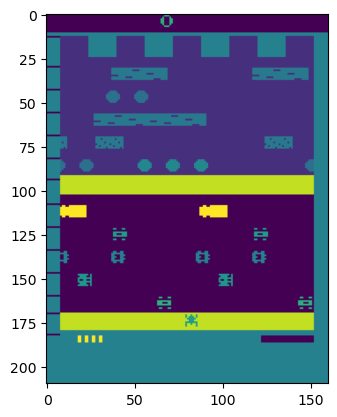

In [7]:
env = gym.make("ALE/Frogger-v5", render_mode="rgb_array", obs_type="grayscale")
obs, info = env.reset()
plt.imshow(obs)
plt.show()

In [9]:
from ultralytics import YOLO
model = YOLO('yolov5s.pt')

PRO TIP  Replace 'model=yolov5s.pt' with new 'model=yolov5su.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.



100%|██████████| 17.7M/17.7M [00:01<00:00, 10.5MB/s]



0: 640x512 (no detections), 503.0ms
Speed: 11.4ms preprocess, 503.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 512)
Available classes: {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'p

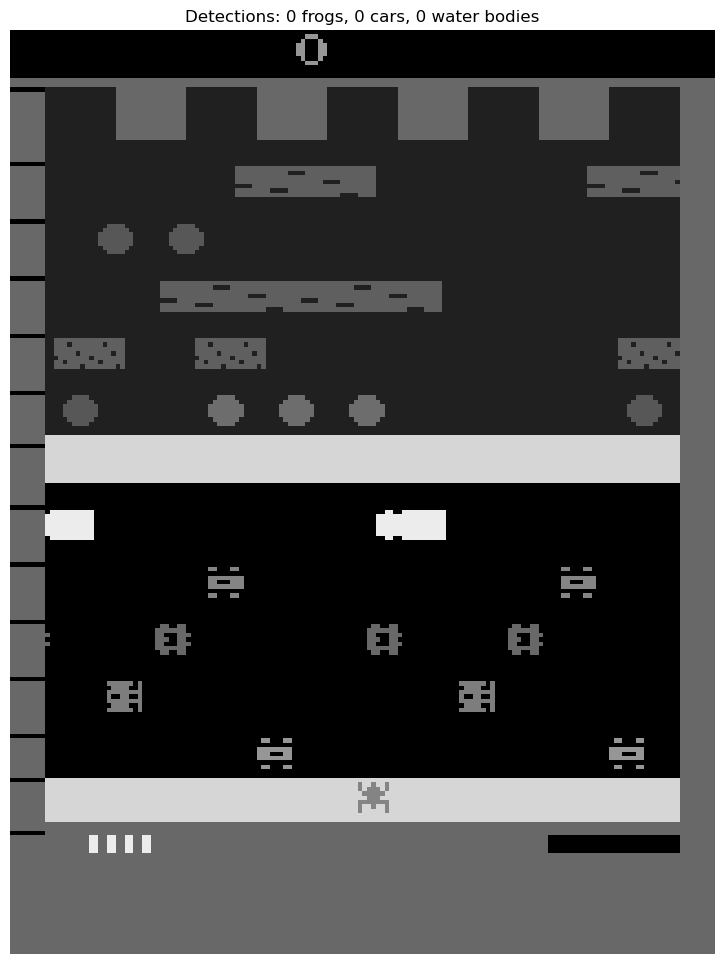

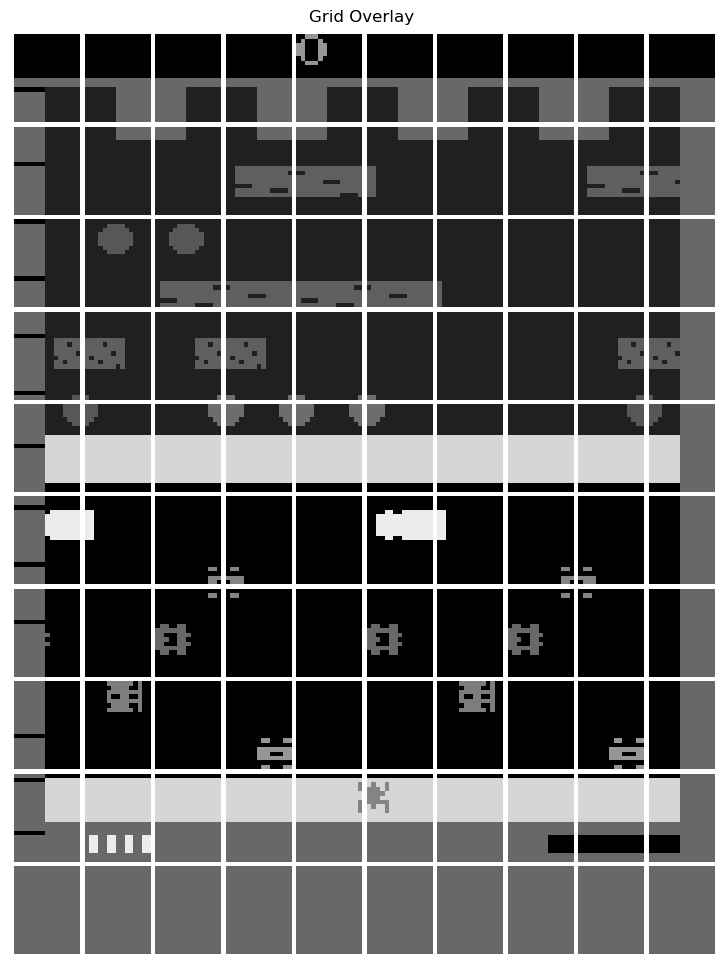

Elapsed time: 513.12 seconds
Final Score: 0.0


In [19]:
def get_grid_positions(detections, grid_size=(10, 10), img_shape=None):
    """Maps object positions to a standardized grid.
    
    Args:
        detections: List of detections (each containing x_center, y_center, width, height)
        grid_size: Tuple of (rows, cols) for the grid
        img_shape: Tuple of (height, width) of the image
    
    Returns:
        List of grid positions as (grid_x, grid_y) tuples
    """
    grid_positions = []
    
    if not detections or len(detections) == 0:
        return []
    
    # If img_shape is provided, use it
    if img_shape:
        height, width = img_shape[:2]
    else:
        # Default to assuming coordinates are in pixels and the observation shape is available
        try:
            height, width = obs.shape[:2]
        except:
            # Fallback to assuming normalized coordinates (0-1)
            height, width = 1.0, 1.0
    
    # Grid cell size
    grid_width = width / grid_size[1]
    grid_height = height / grid_size[0]
    
    for det in detections:
        x_center, y_center = det[0], det[1]
        grid_x = min(max(int(x_center // grid_width), 0), grid_size[1] - 1)
        grid_y = min(max(int(y_center // grid_height), 0), grid_size[0] - 1)
        grid_positions.append((grid_x, grid_y))
    
    return grid_positions

# Process only a single frame
action = env.action_space.sample()  # Sample an action, even though we won't loop
obs, reward, terminated, truncated, info = env.step(action)
score += reward

# Convert observation to a format YOLO understands (e.g., BGR)
obs_bgr = cv2.cvtColor(obs, cv2.COLOR_RGB2BGR)

# Run YOLO object detection
results = model(obs_bgr)

# results is a list, so we access the first item
result = results[0]  # Access the first result (this corresponds to our single frame)

# Print available classes from the model to help with debugging
print("Available classes:", model.names)

# Use the correct method to get detection information
print("Detection results:")
result_df = result.to_df()
print(result_df)

# Extract bounding boxes and class information
frogs = []
cars = []
water = []
other_objects = []

# Get class names from the model
class_names = model.names
print(f"Class names: {class_names}")

# Find the correct class indices based on names (case insensitive)
frog_classes = [i for i, name in class_names.items() if 'frog' in name.lower()]
car_classes = [i for i, name in class_names.items() if 'car' in name.lower() or 'vehicle' in name.lower() or 'truck' in name.lower()]
water_classes = [i for i, name in class_names.items() if 'water' in name.lower() or 'river' in name.lower() or 'lake' in name.lower() or 'pond' in name.lower()]

print(f"Identified frog classes: {frog_classes}")
print(f"Identified car classes: {car_classes}")
print(f"Identified water classes: {water_classes}")

# Loop through each detection
for i in range(len(result.boxes)):
    # Get box coordinates
    box = result.boxes[i]
    xywh = box.xywh[0].cpu().numpy()  # x-center, y-center, width, height
    xyxy = box.xyxy[0].cpu().numpy()  # x1, y1, x2, y2 (top-left and bottom-right corners)
    conf = float(box.conf[0].item())
    cls = int(box.cls[0].item())
    cls_name = class_names.get(cls, f"Unknown-{cls}")
    
    # Complete object info for categorization
    obj_info = {
        'xywh': xywh,
        'xyxy': xyxy,
        'conf': conf,
        'cls': cls,
        'cls_name': cls_name
    }
    
    # Categorize based on class
    if cls in frog_classes:
        frogs.append(obj_info)
    elif cls in car_classes:
        cars.append(obj_info)
    elif cls in water_classes:
        water.append(obj_info)
    else:
        other_objects.append(obj_info)
    
    print(f"Detected {cls_name} (Class ID: {cls}) with confidence {conf:.2f}")

# Get grid positions using xywh coordinates
img_shape = obs.shape
frog_positions = get_grid_positions([f['xywh'] for f in frogs], grid_size=(10, 10), img_shape=img_shape)
car_positions = get_grid_positions([c['xywh'] for c in cars], grid_size=(10, 10), img_shape=img_shape)
water_positions = get_grid_positions([w['xywh'] for w in water], grid_size=(10, 10), img_shape=img_shape)

# Print detections for each category
print(f"Detected {len(frogs)} frogs")
print(f"Detected {len(cars)} cars/vehicles")
print(f"Detected {len(water)} water bodies")
print(f"Detected {len(other_objects)} other objects")

# Print positions (or store them as needed)
print("Frog positions:", frog_positions)
print("Car positions:", car_positions)
print("Water positions:", water_positions)

# Visualize detections
obs_vis = obs_bgr.copy()

# Define colors for visualization
colors = {
    'frog': (0, 255, 0),    # Green
    'car': (0, 0, 255),     # Red
    'water': (255, 0, 0),   # Blue
    'other': (255, 255, 0)  # Cyan
}

# Draw all detections with appropriate colors and labels
for category, objects, color_key in [
    ('Frog', frogs, 'frog'),
    ('Car', cars, 'car'),
    ('Water', water, 'water'),
    ('Other', other_objects, 'other')
]:
    for obj in objects:
        # Get bounding box coordinates
        x1, y1, x2, y2 = map(int, obj['xyxy'])
        cls_name = obj['cls_name']
        conf = obj['conf']
        
        # Draw bounding box
        cv2.rectangle(obs_vis, (x1, y1), (x2, y2), colors[color_key], 2)
        
        # Draw label
        label = f"{cls_name} {conf:.2f}"
        t_size = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.4, 1)[0]
        c2 = x1 + t_size[0], y1 - t_size[1] - 3
        cv2.rectangle(obs_vis, (x1, y1), c2, colors[color_key], -1, cv2.LINE_AA)  # filled
        cv2.putText(obs_vis, label, (x1, y1 - 2), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1, cv2.LINE_AA)

# Display the image with annotations
plt.figure(figsize=(12, 12))
plt.imshow(cv2.cvtColor(obs_vis, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title(f"Detections: {len(frogs)} frogs, {len(cars)} cars, {len(water)} water bodies")
plt.show()

# Draw grid overlay on a copy of the image to show grid positions
grid_vis = obs_vis.copy()
height, width = grid_vis.shape[:2]
cell_height = height / 10
cell_width = width / 10

# Draw grid lines
for i in range(11):
    cv2.line(grid_vis, (0, int(i * cell_height)), (width, int(i * cell_height)), (255, 255, 255), 1)
    cv2.line(grid_vis, (int(i * cell_width), 0), (int(i * cell_width), height), (255, 255, 255), 1)

# Show grid visualization
plt.figure(figsize=(12, 12))
plt.imshow(cv2.cvtColor(grid_vis, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Grid Overlay")
plt.show()

elapsed_time = time.time() - start_time
print(f"Elapsed time: {elapsed_time:.2f} seconds")
print(f"Final Score: {score}")

In [ ]:

obs, info = env.reset()
start_time = time.time()
print("start time:", start_time)
score = 0

for _ in range(1000):
    action = env.action_space.sample() 
    obs, reward, terminated, truncated, info = env.step(action)
    score += reward

    plt.figure(figsize=(6, 6))  # Create a new figure
    plt.imshow(obs)  # Display the observation
    plt.axis("off")  # Hide axes
    plt.show() 
    
    if terminated or truncated:
        break
elapsed_time = time.time() - start_time
print(elapsed_time)
print(f"Final Score: {score}")

